In [1]:
import os
import imageio
import nglview as nv
import numpy as np
import pytraj as pt 
import matplotlib.pyplot as plt
from matplotlib import cm

# import seaborn as sns
from hilbertcurve.hilbertcurve import HilbertCurve
from scipy.ndimage import gaussian_filter


In [26]:
import numpy as np 
import pickle 
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter
from scipy.stats import entropy

class featurizer_3d:
    def __init__(self,pdbFile, trajFile, grid_length, atom_groups, search_cutoff=18, stride=1):
#         self.points = np.zeros(3*grid_length**3).reshape(36**3,3)
        self.length3D = grid_length    
        self.index3D = self.get_points(grid_length)
        self.distances = np.array(range(self.length3D**3));
        self.points3D = self.index3D
        self.atom_groups = atom_groups
        self.cell_length = 1; 
        # Load trajectory
        self.pdbfile = pdbFile; 
        self.trajpdb = pt.load(trajFile, top=pdbFile, stride=stride); 
        print(dir(self.trajpdb))
        self.frameNr = self.trajpdb.n_frames; 
        self.frameList = np.arange(1, self.frameNr*stride+1, stride); 
        self.pdb_atomic_names  = np.array([i.name for i in self.trajpdb.top.atoms]).astype(str)
        self.pdb_atomic_number = np.array([i.atomic_number for i in self.trajpdb.top.atoms]).astype(int)
        self.search_cutoff = search_cutoff; 
        
        self.coordinates = {}
        self.selections   = {}
        for i in atom_groups.keys():
            self.init_group(i, atom_groups[i])
        if 'Ligand' in atom_groups.keys():
            com0 = pt.center_of_mass(self.trajpdb, atom_groups["Ligand"], frame_indices=[0]).squeeze(); 
            print(f"Using ligand to align 3D curve {np.round(com0,2)}")
            self.alignBy = "Ligand"
        else: 
            com0 = pt.center_of_mass(self.trajpdb, atom_groups[atom_groups.keys()[0]], frame_indices=[0]).squeeze();
            print(f"Using {atom_groups.keys()[0]} to align 3D curve {com0}")
            self.alignBy = atom_groups.keys()[0]
        self.alignCenter(com0)
        self.curveCenter = np.mean(self.points3D, axis = 0).reshape(1,3); 
        
    def get_point_by_distance(self, point, length):
        d0 = int(point/length**2)
        d1 = int((point - d0*length**2)/length)
        d3 = int(point - d0*length**2 - d1*length)
        return [d0, d1, d3]
    def get_points(self, length):
        x=[]
        for i in range(length**3):
            x.append(self.get_point_by_distance(i,length))
        return np.array(x).astype(int)
    def Norm_mass_array(self, array, parm = 9, x0=7, slope=0.015):
        line1 = 1/(1+np.e**(-array+x0))
        baseNr = 1/(1+np.e**(-parm+x0))
        line2 = baseNr + (array-parm)*slope
        status1 = array <= parm
        status2 = array > parm
        template = np.zeros(array.shape)
        template[status1] = line1[status1]
        template[status2] = line2[status2]
        return template
    def init_group(self, groupname, mask):
        atom_sel = self.trajpdb.top.select(mask);
        if len(atom_sel) == 0: 
            print(f"Warning: There is no atom selected in the group {groupname}, skipping......"); 
            return 
        else: 
            print(f"Group Name: {groupname}; Atoms: {len(atom_sel)} ")
            self.selections[groupname]  = self.trajpdb.top.select(mask);
            self.coordinates[groupname] = self.trajpdb.xyz[0][self.selections[groupname]]
            
    def featurize(self, features):
        self.features = features = [i.lower() for i in features]
        for feature in features:
            if feature.lower() == 'element':
                print("Featurizing element")
                continue 
                st_elm = time.perf_counter(); 
                # Initialize the container of the descriptors
                self.atom_mass  = {}; 
                self.norm_mass  = {}; 
                self.gauss_mass = {}; 
                for sel in self.selections.keys():
                    self.atom_mass[sel] = []; self.norm_mass[sel] = []; self.gauss_mass[sel] = []; 
                
                # Firstly, Sequentially process each frames 
                for i in range(len(self.trajpdb)):
                    thisxyz = self.trajpdb.xyz[i]; 
                    # Secondly, sequentially process each selection
                    for sel in self.selections.keys():
                        # Thirdly: Extract coordinates within the cutoff, atom index and
                        selidx = self.selections[sel]; 
                        selxyz = thisxyz[selidx]; 
                        # Fourthly: restrain real candidates
                        cand_status = distance_matrix(selxyz, self.curveCenter) <= self.search_cutoff; 
                        cand_status = cand_status.squeeze(); 
                        cand_index  = selidx[cand_status]; 
                        cand_xyz    = selxyz[cand_status]; 
                        cand_distmatrix = distance_matrix(self.points3D, cand_xyz)
                        cand_diststatus = cand_distmatrix < 1.75
                        # cand_distmatrix < 3.75
                        # Step5 : Iterate all 3D points, find nearest points and assign descriptors                        
                        atom_mass = np.zeros((self.length3D, self.length3D, self.length3D));
                        for ind in self.distances:
                            array_3Didx = tuple(self.index3D[ind]); 
                            if np.any(cand_diststatus[ind,:]):
                                rown = cand_distmatrix[ind,:]; 
                                grpidx = np.where(rown == np.min(rown))[0].item();
                                atmidx = cand_index[grpidx]; 
                                the_atomic_number = self.pdb_atomic_number[atmidx]; 
                                atom_mass[array_3Didx] = the_atomic_number
                            else:
                                atom_mass[array_3Didx] = 0; 
                        # Normalize the atom mass and then smoothen the points by gaussian
                        atom_mass_framen = np.array(atom_mass); 
                        norm_mass_framen = self.Norm_mass_array(atom_mass_framen)
                        gauss_mass_framen = gaussian_filter(norm_mass_framen, sigma=1)
                        self.atom_mass[sel].append(atom_mass_framen)
                        self.norm_mass[sel].append(norm_mass_framen)
                        self.gauss_mass[sel].append(gauss_mass_framen)
                for _ in self.selections.keys():
                    self.atom_mass[_] = np.array(self.atom_mass[_]); 
                    self.norm_mass[_] = np.array(self.norm_mass[_]);
                    self.gauss_mass[_]= np.array(self.gauss_mass[_]);
                loadtime = time.perf_counter() - st_elm;
                print(f"Element featurization took {loadtime:.2f} seconds; Avg: {loadtime/self.frameNr:.2f}")
            elif feature.lower() == 'entropy':
                print("Featurizing entropy")
                st_etp = time.perf_counter(); 
                self.entropy  = {}; 
                self.gauss_entropy = {};
                entropy_template=np.zeros((len(self.distances),8))
                # Build key values
                for sel in self.selections.keys():
                    self.entropy[sel] = []; self.gauss_entropy[sel] = []; 
                
#                 np.zeros()
                for i in range(len(self.trajpdb)):
                    # Thirdly: Extract coordinates within the cutoff, atom index and
                    thisxyz = self.trajpdb.xyz[i];
                    self.trajpdb.top.set_reference(self.trajpdb[i])
                    selidx = self.trajpdb.top.select(f":LIG<@{self.search_cutoff}"); 
                    print(f"There are {len(selidx)} atoms selected within cutoff {self.search_cutoff}")
                    
                    selxyz = thisxyz[selidx]; 
                    
                    cand_distmatrix_max = distance_matrix(self.points3D+self.cell_length/2, selxyz)
                    cand_distmatrix_min = distance_matrix(self.points3D-self.cell_length/2, selxyz) 
                    cand_status_max = cand_distmatrix_max < np.sqrt(2); 
                    cand_status_min = cand_distmatrix_min < np.sqrt(2); 
                    
#                     summary = np.array([rowmax*rowmin for rowmax,rowmin in zip(cand_distmatrix_max, cand_distmatrix_min)])
                    summary = cand_status_max*cand_status_min; 
                    print(summary, summary.shape)
                    print(f"Across the loaded trajectory there are {np.count_nonzero(summary)} points")
                    for i in range(len(self.distances)):
                        print(f"point {i} have points: {np.count_nonzero(summary[i])}")
                    print(f"shape of the max matrix: {cand_status_max.shape}, shape of the min matrix: {cand_status_min.shape}.")
                    print(cand_distmatrix_max, cand_distmatrix_max.shape, np.count_nonzero(cand_distmatrix_max), "within 2 Ang max points values")
                    
                    arrand = np.count_nonzero(summary, axis=1)
                    print(arrand, arrand.shape, np.where(arrand>0))
                    print(summary.shape)
                    break
            else: 
                print(f"Decriptor {feature} is not a standard descriptor yet. ")
            
    def alignCenter(self, refCenter):
        diff = np.array(refCenter) - np.mean(self.points3D, axis=0); 
        self.points3D = self.points3D + diff
    def shift(self, shift):
        self.points3D = self.points3D + np.array(shift)
    def scaleToLength(self, refLength):
        scaleFactor = refLength / self.length3D;
        self.cell_length = self.cell_length * scaleFactor; 
        diff = self.points3D - self.index3D
        self.points3D = diff + self.index3D * scaleFactor; 
    def scaleByFactor(self, scaleFactor):
        self.cell_length = self.cell_length * scaleFactor; 
        self.points3D = self.points3D * scaleFactor; 
        
    def save(self, filename):
        with open(filename, "wb") as tmpfile:
            data_to_save={
                "distances":self.distances, 
                "length3D": self.length3D,
                "index3D":self.index3D,
                "points3D":self.points3D,
                
#                 "atom_groups": self.atom_groups, 
#                 "frameNr": self.frameNr,
#                 "frameList": self.frameList,
                         }
            data_to_save["features"] = self.features
            if "element" in self.features:
                data_to_save["atom_mass"] = self.atom_mass
                data_to_save["norm_mass"] = self.norm_mass
                data_to_save["gauss_mass"] = self.gauss_mass
            if "entropy" in self.features:
                data_to_save["entropy"] = 0
            pickle.dump(data_to_save ,tmpfile, protocol=pickle.HIGHEST_PROTOCOL)

            
ATOM_GROUPS = {"Protein":":1-221", "Ligand":":LIG", "Solvent":":T3P,CL-,K+"}
DESCRIPTORS = ["Element", "Entropy"]
GRID_LENGTH = 20       # Unit: points
STRIDE = 50            # Unit: frames
featurizer = featurizer_3d("./test_featurizer.pdb", "./test_featurizer.nc", GRID_LENGTH, ATOM_GROUPS, stride=STRIDE)

featurizer.scaleToLength(18)
featurizer.featurize(DESCRIPTORS)
featurizer.save("test_featurizer_3D.pkl")

# featurizer.alignCenter([18, 18, 18])
# featurizer.shift([3.5,-0.8,1.5])
# featurizer.scaleToLength(18)
# featurizer.scaleByFactor(2)

# print(featurizer.index3D)
# print(featurizer.distances)
# print(featurizer.points3D)


['__add__', '__call__', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_allocate', '_append_unitcells', '_boxes', '_estimated_GB', '_frame_holder', '_handle_setting_box_force_velocity', '_iterframe_indices', '_life_holder', '_top', '_xyz', 'align_principal_axis', 'append', 'append_xyz', 'autoimage', 'center', 'copy', 'forces', 'from_iterable', 'iterframe', 'load', 'n_atoms', 'n_frames', 'rmsfit', 'rotate', 'save', 'scale', 'shape', 'strip', 'superpose', 'time', 'top', 'topology', 'transform', 'translate', 'unitcells', 'velocities', 'view', 'visualize', 'xyz']
Group Name: Protein; Atoms: 3573 
Group Name: Ligand; Atoms: 46 
Group N

point 4014 have points: 0
point 4015 have points: 0
point 4016 have points: 0
point 4017 have points: 0
point 4018 have points: 0
point 4019 have points: 0
point 4020 have points: 0
point 4021 have points: 0
point 4022 have points: 0
point 4023 have points: 0
point 4024 have points: 0
point 4025 have points: 1
point 4026 have points: 0
point 4027 have points: 0
point 4028 have points: 0
point 4029 have points: 0
point 4030 have points: 0
point 4031 have points: 0
point 4032 have points: 0
point 4033 have points: 0
point 4034 have points: 0
point 4035 have points: 0
point 4036 have points: 0
point 4037 have points: 1
point 4038 have points: 0
point 4039 have points: 0
point 4040 have points: 0
point 4041 have points: 0
point 4042 have points: 0
point 4043 have points: 0
point 4044 have points: 0
point 4045 have points: 0
point 4046 have points: 0
point 4047 have points: 0
point 4048 have points: 0
point 4049 have points: 0
point 4050 have points: 0
point 4051 have points: 1
point 4052 h

[[ 7.30803209  6.89216863  5.91771563 ... 17.83417371 17.34576915
  16.89682732]
 [ 7.94069911  7.377761    6.44753665 ... 17.27897914 16.92451116
  16.51375621]
 [ 8.62102498  7.9360397   7.0528079  ... 16.75376043 16.54153708
  16.17175051]
 ...
 [35.82606917 35.35825201 34.28132638 ... 11.12976077 11.53982865
  11.93996784]
 [36.34136213 35.84236814 34.77500121 ... 11.48551014 12.0942555
  12.54209722]
 [36.87142486 36.34232688 35.2847287  ... 11.89883656 12.68835635
  13.17822344]] (8000, 4954) 39632000 within 2 Ang max points values
[0 0 0 ... 0 0 0] (8000,) (array([   4,    5,    8, ..., 7971, 7972, 7985]),)
(8000, 4954)


AttributeError: 'featurizer_3d' object has no attribute 'atom_mass'

In [37]:
traj1= pt.load("test_featurizer.nc", top="test_featurizer.pdb")
print(dir(traj1))
print(traj1.n_frames)
print(traj1.n_atoms)

a = traj1.xyz[0] < np.array([20, 20, 20])
b=np.all(a, axis=1)
print(b.shape)
print(np.count_nonzero(b))


['__add__', '__call__', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_allocate', '_append_unitcells', '_boxes', '_estimated_GB', '_frame_holder', '_handle_setting_box_force_velocity', '_iterframe_indices', '_life_holder', '_top', '_xyz', 'align_principal_axis', 'append', 'append_xyz', 'autoimage', 'center', 'copy', 'forces', 'from_iterable', 'iterframe', 'load', 'n_atoms', 'n_frames', 'rmsfit', 'rotate', 'save', 'scale', 'shape', 'strip', 'superpose', 'time', 'top', 'topology', 'transform', 'translate', 'unitcells', 'velocities', 'view', 'visualize', 'xyz']
201
41152
(41152,)
850


dict_keys(['distances', 'length3D', 'index3D', 'points3D', 'features', 'atom_mass', 'norm_mass', 'gauss_mass', 'entropy'])
[[26.25842196 25.56185355 16.54791903]
 [26.25842196 25.56185355 17.04791903]
 [26.25842196 25.56185355 17.54791903]
 ...
 [43.75842196 43.06185355 33.04791903]
 [43.75842196 43.06185355 33.54791903]
 [43.75842196 43.06185355 34.04791903]]


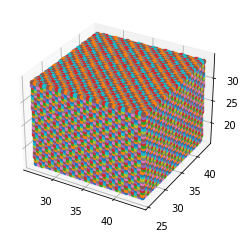

In [21]:
class feature_3d_reader:
    def __init__(self, pickleFile):
        # Generate the 2D/3D hilbert curve
        with open(pickleFile, "rb") as file1:
            featuredic = pickle.load(file1)
            print(featuredic.keys()); 
            self.distances = featuredic["distances"]; 
            self.length3D  = featuredic["length3D"];
            self.points3D  = featuredic["points3D"]; 
            self.index3D   = featuredic["index3D"];
            self.features  = featuredic["features"];
            
#             self.atom_groups = featuredic["atom_groups"]; 
#             self.frameList = featuredic["frameList"]
#             self.frameNr   = featuredic["frameNr"]
            if "element" in self.features:
                self.atom_mass  = featuredic["atom_mass"]
                self.norm_mass  = featuredic["norm_mass"]
                self.gauss_mass = featuredic["gauss_mass"]
            if "entropy" in self.features:
                self.entropy = featuredic["entropy"]
    def scatter3D(self, maintype, select_group, indice, subtype="gauss"):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        plt.ion()
        
        cmap_protein = cm.get_cmap("Blues")
        for i in self.distances: 
            theposition = self.points3D[i].tolist(); 
            theindex = self.index3D[i]; 
            mass_val = protein_normmass[tuple(theindex)]
            thecolor = cmap_protein(mass_val)
            if mass_val > 0.1:
                print(f"{mass_val}, color is {thecolor}")
                ax.scatter(*theposition, color=thecolor)
        
reader = feature_3d_reader("test_featurizer_3D.pkl")
print(reader.points3D)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in reader.distances: 
    theposition = reader.points3D[i].tolist(); 
    ax.scatter(*theposition)


In [26]:
from scipy.stats import entropy

a=np.ones(10)
b=np.zeros(10)+130
c=np.arange(0,10,1)
d = np.arange(0,20,2)

print(len(c), len(d))

print(entropy(d))
# print(entropy(b))
print(entropy(c))
# entropy([1,1,22,3,12,1,2,2,3,4.34])

10 10
2.0498407203926647
2.0498407203926647


In [76]:
a=np.array([True,False,True,False]).reshape((2,2))
b=np.array([True,True,False,False]).reshape((2,2))
print(a)
print(b)

print(np.multiply(a,b))
for i, j in zip(a,b):
    print("=>",i*j)
    
    
print([i*j for i, j in zip(a,b)])

[[ True False]
 [ True False]]
[[ True  True]
 [False False]]
[[ True False]
 [False False]]
=> [ True False]
=> [False False]
[array([ True, False]), array([False, False])]


In [36]:
import pytraj as pt 
traj1 = pt.load("test_featurizer.pdb", top='test_featurizer.pdb')
traj1.top.set_reference(traj1[0])
a = traj1.top.select(":LIG<@18")
print(len(a))

4991
